✅ Data Loaded Successfully!
Starting Anomaly Detection...


/tmp/ipykernel_47/2629460831.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  self.df['minute'] = self.df['datetime'].dt.floor('T')  # Round to nearest minute


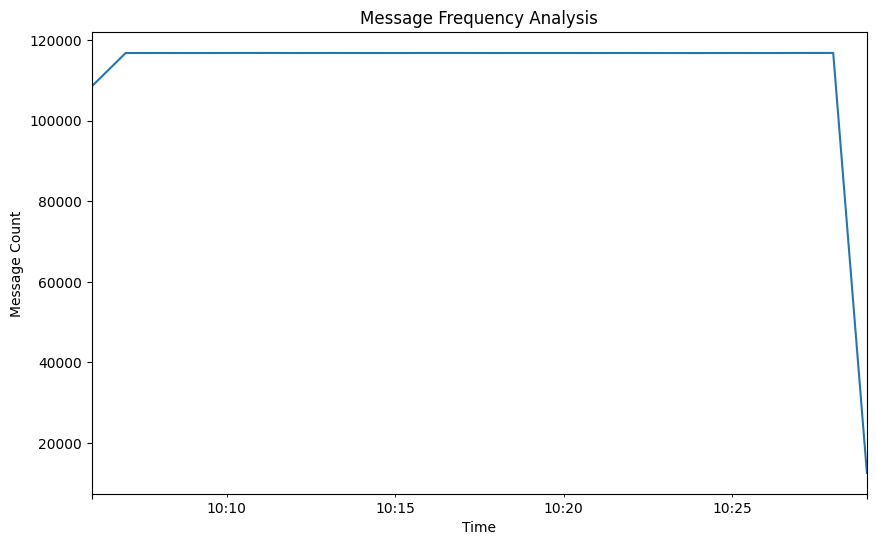

Anomalous Message Frequencies:
Series([], dtype: int64)


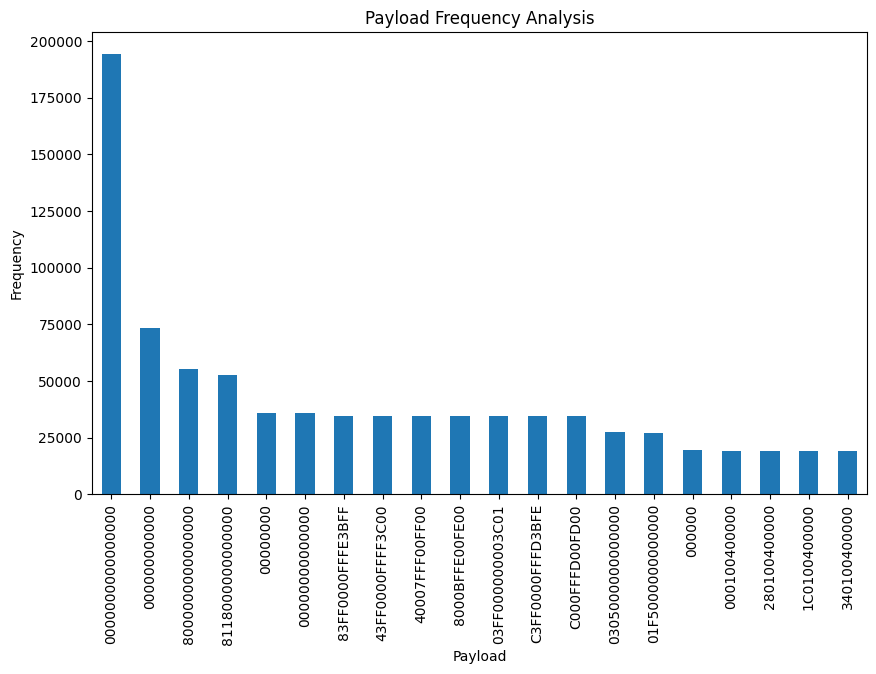

Rare Payloads (Anomalies):
payload
2C1F2C1F2EE807FF    4
03D403D41B          4
5CFFF930040002C4    4
070D068900003500    4
800F2D0D00011000    4
                   ..
801FAF0D2B001004    1
2C45AF0D2B001004    1
A1873A2E621CEE79    1
23DF756BE0AD28A2    1
2C45B20A2B001004    1
Name: count, Length: 668356, dtype: int64


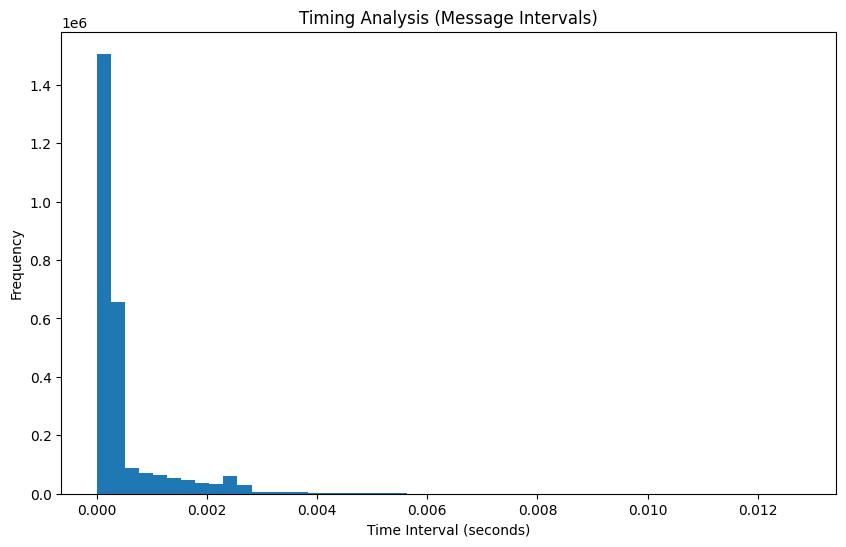

Anomalous Time Intervals:
56         0.003170
155        0.002815
184        0.002702
346        0.002914
390        0.002696
             ...   
2689333    0.003361
2689523    0.005602
2689631    0.003765
2689712    0.003117
2689915    0.003126
Name: time_diff, Length: 49520, dtype: float64


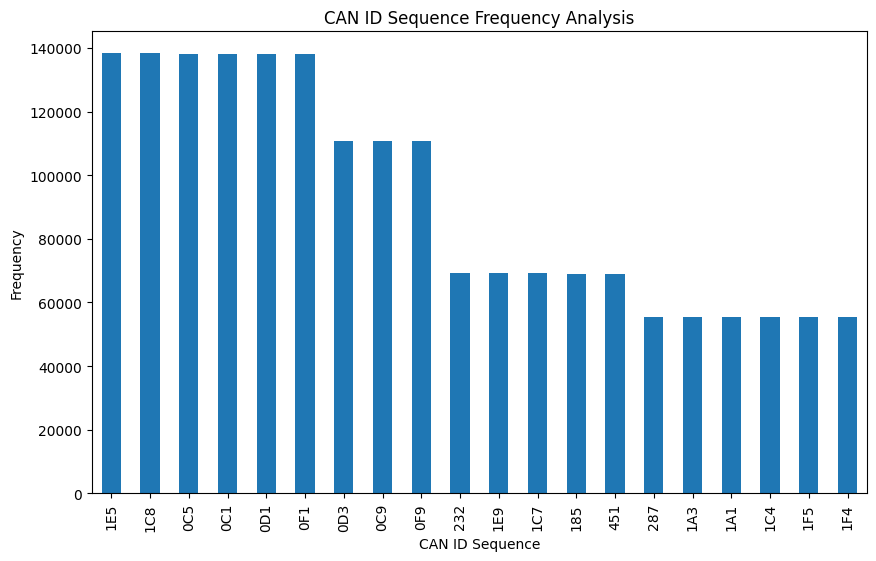

Rare CAN ID Sequences (Anomalies):
can_id_sequence
start    1
Name: count, dtype: int64


In [1]:
import pandas as pd
import numpy as np
import os
import bz2
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore

class CANBusAnomalyDetection:
    def __init__(self, df, window_size=10):
        self.df = df
        self.window_size = window_size

    def message_frequency_analysis(self, time_window=60):
        """Analyze the frequency of messages over time."""
        # Resample the data into specified time windows (e.g., 60 seconds)
        self.df['minute'] = self.df['datetime'].dt.floor('T')  # Round to nearest minute
        frequency = self.df.groupby('minute').size()  # Message count per minute

        # Plot the frequency distribution
        plt.figure(figsize=(10, 6))
        frequency.plot(kind='line')
        plt.title("Message Frequency Analysis")
        plt.xlabel("Time")
        plt.ylabel("Message Count")
        plt.show()

        # Find anomalies using Z-score
        frequency_zscore = zscore(frequency)
        anomalies = frequency[frequency_zscore > 3]  # Example threshold for anomaly (Z-score > 3)
        print(f"Anomalous Message Frequencies:\n{anomalies}")

    def payload_pattern_analysis(self):
        """Analyze the payload patterns."""
        # Find unique payloads and their frequency
        payload_counts = self.df['payload'].value_counts()

        # Plot payload frequency
        plt.figure(figsize=(10, 6))
        payload_counts.head(20).plot(kind='bar')  # Top 20 most common payloads
        plt.title("Payload Frequency Analysis")
        plt.xlabel("Payload")
        plt.ylabel("Frequency")
        plt.show()

        # Detect anomalies (payloads with very low frequency)
        threshold = 5  # Example threshold for anomaly (payloads appearing less than 5 times)
        rare_payloads = payload_counts[payload_counts < threshold]
        print(f"Rare Payloads (Anomalies):\n{rare_payloads}")

    def timing_analysis(self):
        """Analyze message timing."""
        self.df['time_diff'] = self.df['timestamp'].diff().fillna(0)  # Calculate time differences
        plt.figure(figsize=(10, 6))
        self.df['time_diff'].plot(kind='hist', bins=50)
        plt.title("Timing Analysis (Message Intervals)")
        plt.xlabel("Time Interval (seconds)")
        plt.ylabel("Frequency")
        plt.show()

        # Detect anomalies based on Z-score
        time_diff_zscore = zscore(self.df['time_diff'])
        anomalies = self.df['time_diff'][time_diff_zscore > 3]  # Example: Z-score > 3
        print(f"Anomalous Time Intervals:\n{anomalies}")

    def can_id_sequence_analysis(self):
        """Analyze CAN ID sequences."""
        # Create a sequence of CAN IDs
        self.df['can_id_sequence'] = self.df['can_id'].astype(str).shift(1).fillna('start')  # Sequence with the previous CAN ID

        # Check for frequent sequence breaks (anomalies)
        can_id_sequence_counts = self.df['can_id_sequence'].value_counts()

        plt.figure(figsize=(10, 6))
        can_id_sequence_counts.head(20).plot(kind='bar')
        plt.title("CAN ID Sequence Frequency Analysis")
        plt.xlabel("CAN ID Sequence")
        plt.ylabel("Frequency")
        plt.show()

        # Identify CAN ID sequences that don't follow expected patterns (e.g., rare or unexpected sequences)
        threshold = 5  # Example threshold for anomaly (sequences with fewer than 5 occurrences)
        rare_sequences = can_id_sequence_counts[can_id_sequence_counts < threshold]
        print(f"Rare CAN ID Sequences (Anomalies):\n{rare_sequences}")

    def run_anomaly_detection(self):
        """Run all the anomaly detection methods."""
        print("Starting Anomaly Detection...")

        # Message Frequency Analysis
        self.message_frequency_analysis()

        # Payload Pattern Analysis
        self.payload_pattern_analysis()

        # Timing Analysis
        self.timing_analysis()

        # CAN ID Sequence Analysis
        self.can_id_sequence_analysis()

# Load and preprocess the data
class CANBusML:
    def __init__(self, window_size=10):
        self.window_size = window_size

    def load_data(self, file_path):
        """Load and preprocess CAN bus data."""
        extracted_file_path = file_path.replace(".bz2", "")
        
        if file_path.endswith(".bz2"):
            with bz2.BZ2File(file_path, "rb") as fr, open(extracted_file_path, "wb") as fw:
                fw.write(fr.read())
            file_path = extracted_file_path

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Error: File '{file_path}' not found.")

        data = []
        with open(file_path, "r") as file:
            for line in file:
                parts = line.strip().split()
                if len(parts) < 3:
                    continue  
                try:
                    timestamp = float(parts[0].strip("()"))
                    can_id, payload = parts[2].split("#")

                    data.append({
                        "timestamp": timestamp,
                        "datetime": datetime.fromtimestamp(timestamp),
                        "can_id": can_id,
                        "payload": payload,
                        "payload_length": len(payload),
                    })
                except (ValueError, IndexError):
                    continue  

        df = pd.DataFrame(data)
        print("✅ Data Loaded Successfully!")
        return df

# 🏁 Run Pipeline
file_path = "/workspaces/myfolder/full_data_capture.log.bz2"
pipeline = CANBusML(window_size=10)
df = pipeline.load_data(file_path)

# Run Anomaly Detection
anomaly_detector = CANBusAnomalyDetection(df)
anomaly_detector.run_anomaly_detection()
